# Static Categorical with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of static categorical columns with a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

We create a dataset from two base datasets adding an ID column, which we will also use as a static categorical feature.


## Installation

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12"

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

## Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
dataset_path_1 = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
dataset_path_2 = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

# ----- TTM model path -----
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
TTM_MODEL_REVISION = "main"


## Data processing pipeline

**Note:** Here we demonstrate how to use the TimeSeriesPreprocessor (TSP) module for data preparation. A step-by-step usage is shown below. For standard datasets, TSP can quickly prepare the dataloaders using YAML files defined [here](https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/resources/data_config). Refer to the [TTM Getting Started](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb) for example usage. Similar YAML file can be written for any new dataset as well.


In [3]:
# Load the data file and see the columns
timestamp_column = "date"
df1 = pd.read_csv(dataset_path_1, parse_dates=[timestamp_column],)
df1["id"] = "m1"
df2 = pd.read_csv(dataset_path_2, parse_dates=[timestamp_column],)
df2["id"] = "m2"
df = pd.concat([df1, df2])
df["series"] = df.id
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,id,series
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999,m1,m1
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000,m1,m1
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002,m1,m1
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001,m1,m1
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001,m1,m1


In [5]:

timestamp_column = "date"
id_columns = ["id"]
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24 * 4],
    "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
    "test": [
        12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
        12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
    ],
}


column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "static_categorical_columns": ["series"]
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, df, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 3214, val = 22850, test = 22850


In [27]:
tsp.__dict__

{'id_columns': ['id'],
 'timestamp_column': 'date',
 'target_columns': ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'],
 'observable_columns': [],
 'control_columns': [],
 'conditional_columns': [],
 'static_categorical_columns': ['id'],
 'context_length': 512,
 'prediction_length': 96,
 'scaling': True,
 'encode_categorical': True,
 'time_series_task': 'forecasting',
 'scaler_type': 'standard',
 'scaling_id_columns': ['id'],
 'scaler_dict': {},
 'target_scaler_dict': {'m1': StandardScaler(), 'm2': StandardScaler()},
 'categorical_encoder': OrdinalEncoder(),
 'frequency_mapping': {'oov': 0,
  'min': 1,
  '2min': 2,
  '5min': 3,
  '10min': 4,
  '15min': 5,
  '30min': 6,
  'h': 7,
  'd': 8,
  'W': 9},
 'freq': '0 days 00:15:00',
 '_processor_class': 'TimeSeriesPreprocessor'}

Note that the dataset now contains `static_categorical_values`, which contains the encoded version of the categorical data.

In [25]:
train_dataset[0]["static_categorical_values"]

tensor([0.])

## REMOVE Zero-shot evaluation method

In [69]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, num_input_channels=tsp.num_input_channels)
zeroshot_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [70]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

In [71]:
zeroshot_trainer.evaluate(test_dataset)

  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.2570821940898895,
 'eval_model_preparation_time': 0.0064,
 'eval_runtime': 14.8782,
 'eval_samples_per_second': 1535.807,
 'eval_steps_per_second': 24.062}

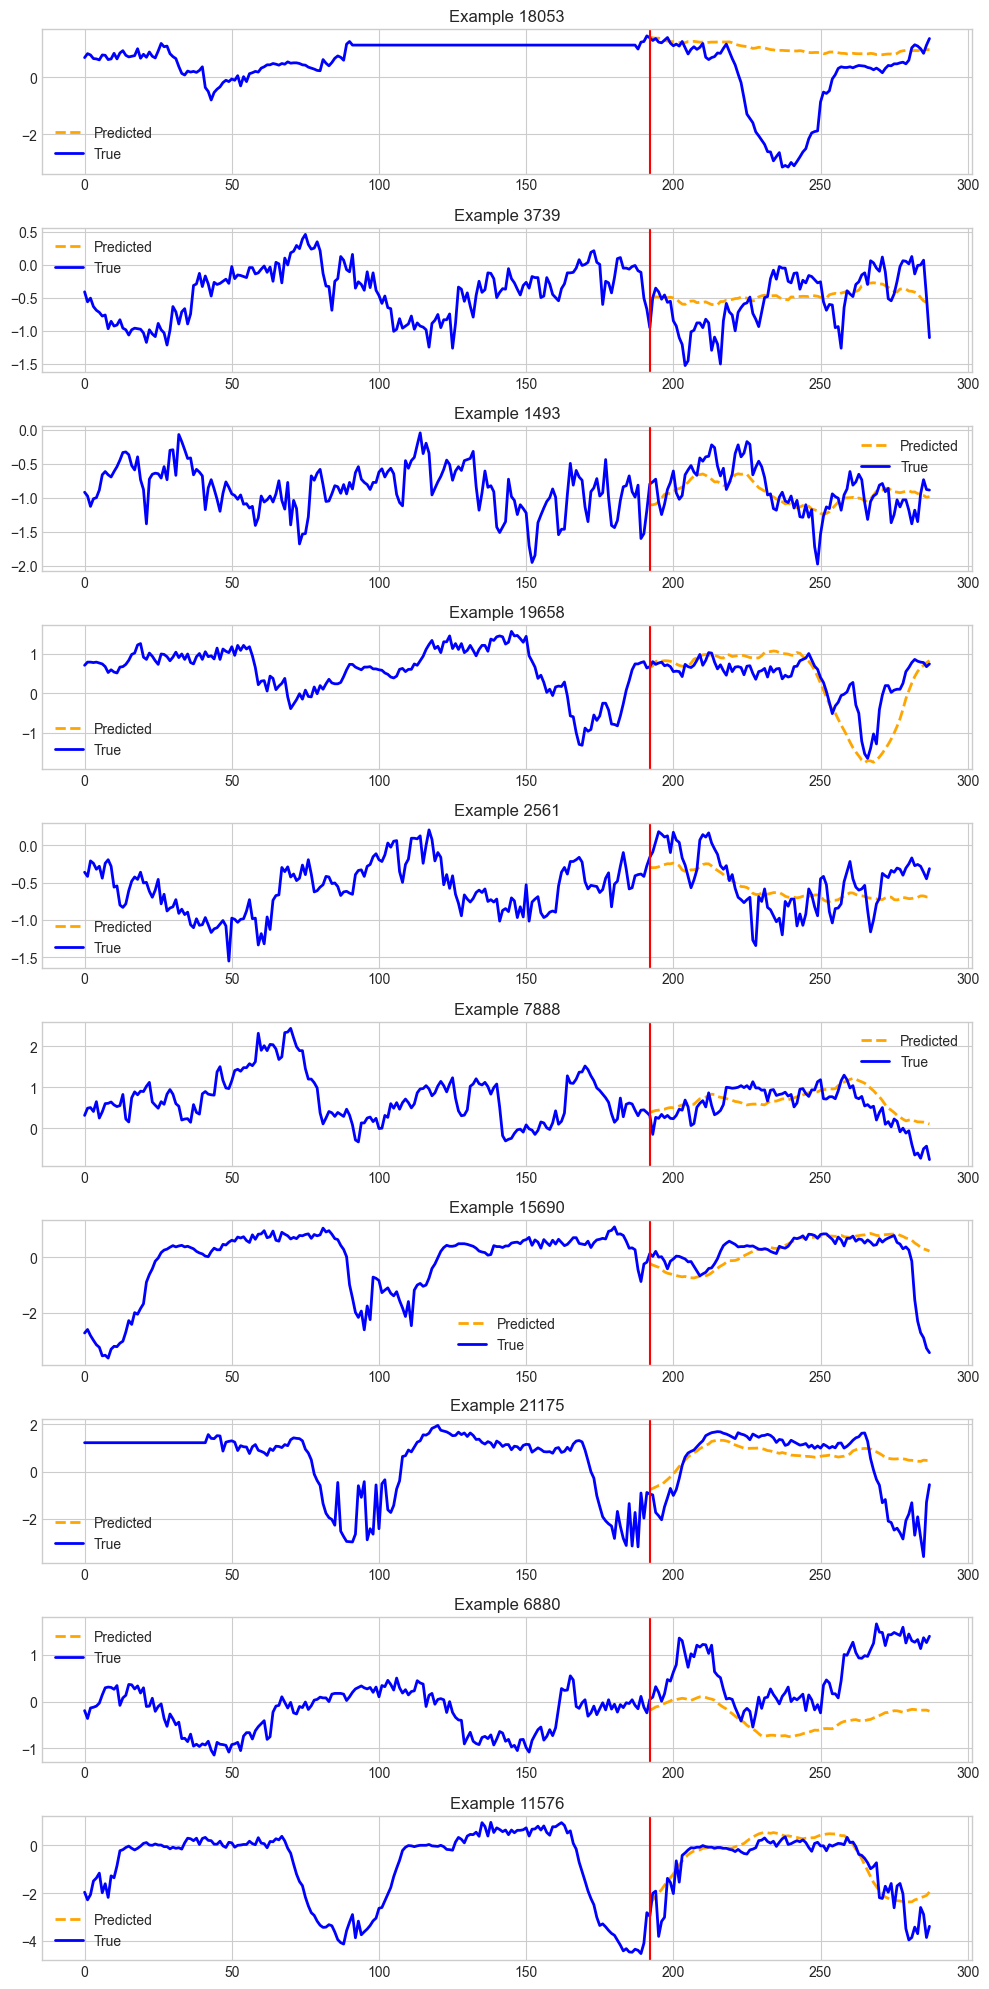

In [72]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "ettm2"),
    plot_prefix="test_zeroshot",
    channel=0,
    # indices=[11032]
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [7]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7, num_input_channels=tsp.num_input_channels, prediction_channel_indices=tsp.prediction_channel_indices
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Frezze the TTM backbone

In [8]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Finetune few-shot 5%

In [73]:
# Important parameters
learning_rate = 0.001
num_epochs = 20  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [74]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=2,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

import numpy as np
from transformers import EvalPrediction

def compute_metrics(pred : EvalPrediction):
  return {"rmse": np.sqrt(np.square(pred.predictions[0] - pred.label_ids).mean())}

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

# Fine tune
out = finetune_forecast_trainer.train()

Using learning rate = 0.001


  0%|          | 0/1020 [00:00<?, ?it/s]

INFO:p-55159:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55164:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1414, 'grad_norm': 0.2653622031211853, 'learning_rate': 0.00010472043067926589, 'epoch': 1.0}


INFO:p-55204:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55205:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.30905652046203613, 'eval_runtime': 26.4446, 'eval_samples_per_second': 864.07, 'eval_steps_per_second': 13.538, 'epoch': 1.0}


INFO:p-55279:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55288:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1681, 'grad_norm': 0.4623734951019287, 'learning_rate': 0.0002814286637699402, 'epoch': 2.0}


INFO:p-55332:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55335:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.30902913212776184, 'eval_runtime': 26.1386, 'eval_samples_per_second': 874.186, 'eval_steps_per_second': 13.696, 'epoch': 2.0}


INFO:p-55375:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55415:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1762, 'grad_norm': 0.35524529218673706, 'learning_rate': 0.0005224720619795203, 'epoch': 3.0}


INFO:p-55454:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55458:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.30776622891426086, 'eval_runtime': 26.3774, 'eval_samples_per_second': 866.272, 'eval_steps_per_second': 13.572, 'epoch': 3.0}


INFO:p-55505:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55513:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1734, 'grad_norm': 0.35799044370651245, 'learning_rate': 0.0007628488230391824, 'epoch': 4.0}


INFO:p-55553:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55586:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.32197901606559753, 'eval_runtime': 26.3597, 'eval_samples_per_second': 866.854, 'eval_steps_per_second': 13.581, 'epoch': 4.0}


INFO:p-55627:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55633:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1716, 'grad_norm': 0.2792896628379822, 'learning_rate': 0.0009377369156944745, 'epoch': 5.0}


INFO:p-55673:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55674:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3277466893196106, 'eval_runtime': 26.4244, 'eval_samples_per_second': 864.732, 'eval_steps_per_second': 13.548, 'epoch': 5.0}


INFO:p-55778:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55787:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1706, 'grad_norm': 0.2852376699447632, 'learning_rate': 0.0009999951600498044, 'epoch': 6.0}


INFO:p-55838:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55839:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3196899890899658, 'eval_runtime': 26.3006, 'eval_samples_per_second': 868.803, 'eval_steps_per_second': 13.612, 'epoch': 6.0}


INFO:p-55915:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55922:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1688, 'grad_norm': 0.37268489599227905, 'learning_rate': 0.0009869697462603758, 'epoch': 7.0}


INFO:p-55971:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-55976:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3238893151283264, 'eval_runtime': 26.4984, 'eval_samples_per_second': 862.316, 'eval_steps_per_second': 13.51, 'epoch': 7.0}


INFO:p-56052:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56068:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1687, 'grad_norm': 0.37383902072906494, 'learning_rate': 0.0009495257362732281, 'epoch': 8.0}


INFO:p-56108:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56109:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.32368168234825134, 'eval_runtime': 26.3011, 'eval_samples_per_second': 868.786, 'eval_steps_per_second': 13.612, 'epoch': 8.0}


INFO:p-56150:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56190:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1669, 'grad_norm': 0.2808060944080353, 'learning_rate': 0.000889540729101686, 'epoch': 9.0}


INFO:p-56233:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56237:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.32147207856178284, 'eval_runtime': 26.4246, 'eval_samples_per_second': 864.726, 'eval_steps_per_second': 13.548, 'epoch': 9.0}


INFO:p-56292:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56304:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.166, 'grad_norm': 0.331744521856308, 'learning_rate': 0.0008100226234809076, 'epoch': 10.0}


INFO:p-56349:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56354:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3401126563549042, 'eval_runtime': 25.9608, 'eval_samples_per_second': 880.172, 'eval_steps_per_second': 13.79, 'epoch': 10.0}


INFO:p-56429:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56440:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1651, 'grad_norm': 0.4434451460838318, 'learning_rate': 0.0007149587892654108, 'epoch': 11.0}


INFO:p-56478:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56479:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3379639983177185, 'eval_runtime': 26.7824, 'eval_samples_per_second': 853.171, 'eval_steps_per_second': 13.367, 'epoch': 11.0}


INFO:p-56554:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56560:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1637, 'grad_norm': 0.4020010530948639, 'learning_rate': 0.0006091161240547627, 'epoch': 12.0}


INFO:p-56606:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56612:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3371213972568512, 'eval_runtime': 26.4987, 'eval_samples_per_second': 862.306, 'eval_steps_per_second': 13.51, 'epoch': 12.0}


INFO:p-56690:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56696:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


{'loss': 0.1635, 'grad_norm': 0.3525620996952057, 'learning_rate': 0.0004978020210431059, 'epoch': 13.0}


INFO:p-56740:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-56741:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/358 [00:00<?, ?it/s]

{'eval_loss': 0.3392242193222046, 'eval_runtime': 26.6404, 'eval_samples_per_second': 857.721, 'eval_steps_per_second': 13.438, 'epoch': 13.0}
{'train_runtime': 585.7533, 'train_samples_per_second': 109.739, 'train_steps_per_second': 1.741, 'train_loss': 0.16646591966148594, 'epoch': 13.0}
[TrackingCallback] Mean Epoch Time = 18.588450541863075 seconds, Total Train Time = 585.7521798610687


### Evaluate performance
We split the test dataset into the subsets associated with the original m1 and m2 datasets and use the evaluate method of the trainer. We also plot some sample time series.

In [61]:
from torch.utils.data import Subset
first_id = test_dataset[0]["id"]
for i, rec in enumerate(test_dataset):
    if rec["id"] != first_id:
        break

test_m1 = Subset(test_dataset, range(i))
test_m2 = Subset(test_dataset, range(i, len(test_dataset)))

print(finetune_forecast_trainer.evaluate(test_m1))
print(finetune_forecast_trainer.evaluate(test_m2))

INFO:p-52815:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-52818:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/179 [00:00<?, ?it/s]

{'eval_loss': 0.1800858974456787, 'eval_runtime': 20.6937, 'eval_samples_per_second': 552.1, 'eval_steps_per_second': 8.65, 'epoch': 2.0}


INFO:p-52902:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.
INFO:p-52907:t-8667275520:config.py:<module>:PyTorch version 2.4.1 available.


  0%|          | 0/179 [00:00<?, ?it/s]

{'eval_loss': 0.37988564372062683, 'eval_runtime': 20.587, 'eval_samples_per_second': 554.963, 'eval_steps_per_second': 8.695, 'epoch': 2.0}


Now we plot a few results from each subset of the test dataset

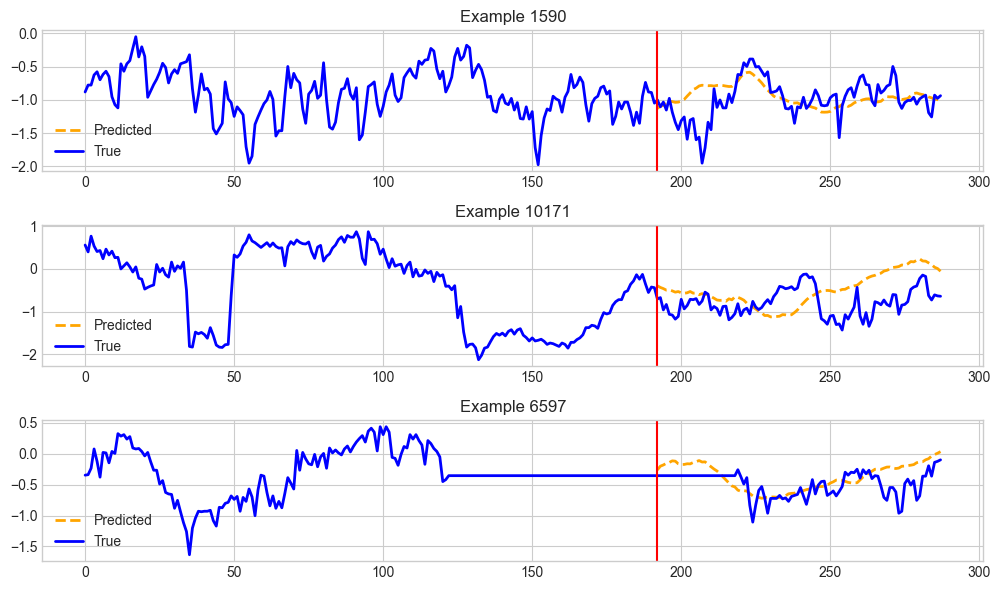

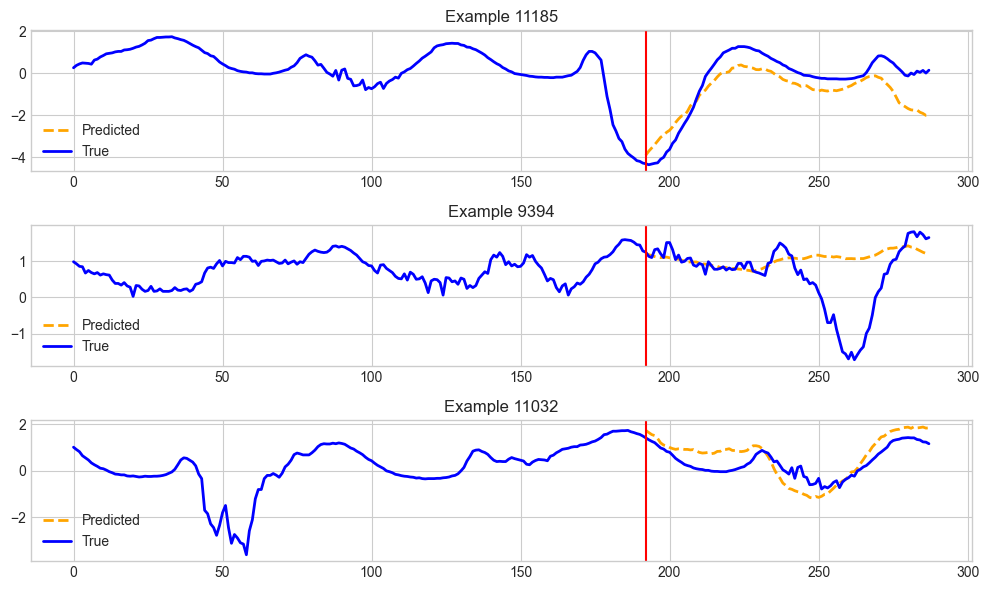

In [63]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_m1,
    plot_prefix="test_zeroshot",
    channel=0,
    num_plots=3
)

plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_m2,
    plot_prefix="test_zeroshot",
    channel=0,
    num_plots=3
)